# Population of Turkey's provinces and Izmir's town
In this projest, population of 81 province in Turkey will be shown as Turkey's map. Chlorap will be used.
Similarly population of İzmir's towns will be shown.
- Population of each province will be taken from excel file.
- populations will be inserted into Turkey's geodataframe from Turkeys province shape file.
- Province names and populations will be placed on the map

In [1]:
%matplotlib inline

import pandas as pd
import geopandas

pd.options.display.max_rows = 10

## Maps and shape files
gadm36_TUR_0.shp Turkey in general  
gadm36_TUR_0.shp Turkey/provinces  
gadm36_TUR_0.shp Turkey/towns  
https://gadm.org/index.html shape files can be download.

In [7]:
provinces = geopandas.read_file("data/gadm36_TUR_1.shp", encoding = 'utf-8')

In [8]:
provinces.head()

,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry
0,TUR,Turkey,TUR.1_1,Adana,Seyhan,None,Il,Province,None,TR.AA,"(POLYGON ((35.20958328 36.67874908, 35.2095832..."
1,TUR,Turkey,TUR.2_1,Adiyaman,Adıyaman,None,Il,Province,None,TR.AD,"POLYGON ((38.68339157 37.60322571, 38.66181564..."
2,TUR,Turkey,TUR.3_1,Afyon,Afyonkarahisar,None,Il,Province,None,TR.AF,"POLYGON ((30.18260765 37.90116119, 30.18877983..."
3,TUR,Turkey,TUR.4_1,Agri,Ağri|Karaköse,None,Il,Province,None,TR.AG,"POLYGON ((43.71635437 39.37020493, 43.7074585 ..."
4,TUR,Turkey,TUR.5_1,Aksaray,None,None,Il,Province,None,TR.AK,"POLYGON ((34.39512634 38.19466782, 34.39625931..."


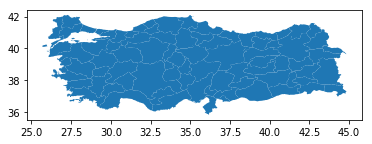

In [9]:
provinces.plot()

Change coordinate system
CRS

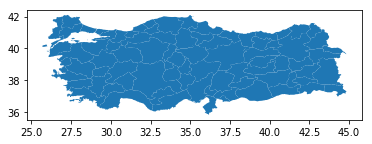

In [11]:
provinces.to_crs(epsg=3395)
provinces.plot()

In [ ]:
provinces